# Visualisation Tool

## Import libraries

In [6]:
# Use visual conda environment
from transformers import BertModel, BertTokenizer
from bertviz import model_view, head_view
import torch
import torch.nn as nn
from transformers import BertModel, BertTokenizer
from bertviz import model_view, head_view
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
import numpy as np
import torch.nn.functional as F

## Load Model Checkpoint

In [7]:
# Define your local model path
model_path = "../models/CheXbert/model_path/chexbert.pth"
# model_path = "../data_msc_project/bertdata/batch64-please4-bluebert-balancedset-chexblabeled/model_epoch8_iter4000"

## Define an input text report

In [23]:
# input_text = """Mild pulmonary edema superimposed on known lung fibrosis. Severe
#  chronic cardiomegaly and pulmonary hypertension. No displaced rib fracture. 
#  Multiple vertebroplasties, similar to prior."""

# input_text = """No definite evidence for congestive heart failure.  Patchy
#  streaky opacity in the right lung base likely reflects atelectasis though
#  infection is difficult to exclude."""

# input_text = """In comparison with study of ___, the width of the mediastinum
#  has decreased.  The cardiac silhouette is within normal limits.  Minimal
#  atelectasis at the left base but no vascular congestion or acute focal
#  pneumonia."""

# input_text = """As compared to the previous radiograph, the known right
#  pneumothorax is stable.
 
#  On the left, there is major evidence of pneumothorax.  The right pleural effusion
#  has completely resolved.  Abnormally enlarged cardiac silhouette.  Normal hilar
#  and mediastinal contours."""

# input_text = "Overall stable exam with extensive metastatic disease to the \n lungs with right pleural effusion and right basal consolidation."

# input_text = "There is no pneumonia."

# input_text = """In the hole in the ground there lived a hobbit. And not a nasty, dirty, wet hole, filled with the ends of worms and an oozy smell, nor yet a dry, bare, sandy hole with nothing in it to sit down on or to eat: it was a hobbit-hole, and that means comfort."""

# input_text = """When shall we three meet again, in thunder, lightning, or in rain? When the hurlyburly's done, when the battle's lost and won. That will be ere the set of sun."""

input_text = """Large patches on the lungs which are inflamed, with a small amount of fluid in the pleural space. The heart is abnormally enlarged in size. The mediastinum is unremarkable."""

# input_text = """As compared to the previous radiograph, there is no relevant
#  change.  The monitoring and support devices are constant.  Low lung volumes,
#  borderline size of the cardiac silhouette.  Mild pulmonary edema.  Moderate
#  retrocardiac atelectasis.  No evidence of pneumonia."""

## Compute Token Weights
- Getting output token embeddings from base model
- Computing token weights using linear head's weight matrices
- Normalisation of token weights

In [24]:
# Load the tokenizer from the same model used to train chexbert.pth
tokenizer_name = "bert-base-uncased"  # Replace with the correct tokenizer if different
tokenizer = BertTokenizer.from_pretrained(tokenizer_name)

# Define a modified BERT model with an additional layer
class ChexbertModel(nn.Module):
    def __init__(self):
        super(ChexbertModel, self).__init__()
        self.bert = BertModel.from_pretrained(tokenizer_name, output_attentions=True)
        self.linear_heads = nn.ModuleList([nn.Linear(768, 4) if i < 13 else nn.Linear(768, 2) for i in range(14)])  # Adjusting the sizes to match the state dict

    def forward(self, input_ids, attention_mask=None, token_type_ids=None):
        outputs = self.bert(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        sequence_output = outputs[0]
        additional_outputs = [head(sequence_output) for head in self.linear_heads]
        return outputs + (additional_outputs,)

# Initialize the model
model = ChexbertModel()

# Load the state dictionary
state_dict = torch.load(model_path)

# Extract the actual model state dictionary if necessary
if 'model_state_dict' in state_dict:
    state_dict = state_dict['model_state_dict']

# Remove the `module.` and `bert.` prefixes if they exist
new_state_dict = {}
for key, value in state_dict.items():
    if key.startswith('module.bert.'):
        new_key = key[7:]  # Remove `module.` prefix
    elif key.startswith('bert.'):
        new_key = key  # No change needed
    elif key.startswith('module.'):
        new_key = key[7:]  # Remove `module.` prefix
    else:
        new_key = key

    new_state_dict[new_key] = value

# Load the model weights from the adjusted state dictionary
model.load_state_dict(new_state_dict, strict=False)

# Tokenize input text
inputs = tokenizer.encode(input_text, return_tensors='pt')

# Run model
outputs = model(inputs)

# Retrieve additional outputs (linear heads)
additional_outputs = outputs[-1]

# Convert input ids to token strings
tokens = tokenizer.convert_ids_to_tokens(inputs[0])

# Compute the impact of each token on the output of each linear head
def compute_token_impact(sequence_output, linear_heads):
    impacts = []
    for head in linear_heads:
        # Compute the impact of each token by using the dot product between the token embeddings and the weights of the linear head
        token_impacts = torch.matmul(sequence_output, head.weight.t()) + head.bias
        # Normalize the impacts
        token_impacts = token_impacts.detach().cpu().numpy()
        impacts.append(token_impacts)
    return impacts

# Get sequence output from the model
sequence_output = outputs[0].squeeze(0)

# Compute the impacts
token_impacts = compute_token_impact(sequence_output, model.linear_heads)

# Print size of list
print(len(token_impacts))
print(token_impacts[0].shape)

# Normalize the impacts
for i in range(len(token_impacts)):
    min = np.min(token_impacts[i].flatten())
    max = np.max(token_impacts[i].flatten())
    for j in range(len(token_impacts[i])):
        token_impacts[i][j] = (token_impacts[i][j] - min) / (max - min)


14
(46, 4)


## Visualising through heatmap
- Show token weights for relevant classes

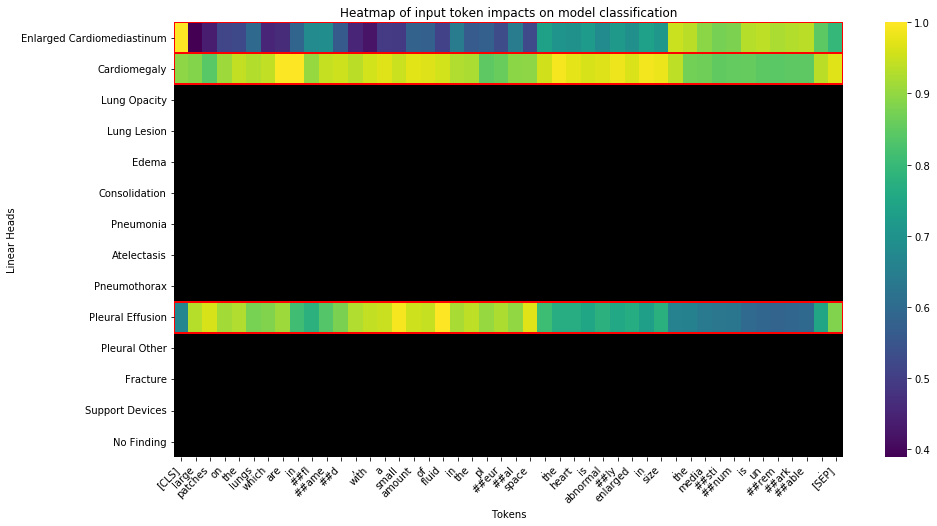

In [25]:
def visualize_highest_sum_bars(token_impacts, tokens):
    yticklabels = ['Blank', 'Positive', 'Negative', 'Uncertain']
    linear_head_labels = ['Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity', 'Lung Lesion', 'Edema',
                          'Consolidation', 'Pneumonia', 'Atelectasis', 'Pneumothorax', 'Pleural Effusion',
                          'Pleural Other', 'Fracture', 'Support Devices', 'No Finding']
    
    # Create an empty list to store the highest sum rows
    highest_sum_rows = []
    highest_sum_labels = []

    # Track rows that should be outlined in red
    rows_to_outline = []

    for i, impact in enumerate(token_impacts):
        # Calculate the total sum of values for each class (horizontal bar)
        class_sums = np.sum(impact, axis=0)
        
        # Find the class with the highest total sum
        max_class_index = np.argmax(class_sums)
        
        # Append the corresponding row to the list
        highest_sum_rows.append(impact[:, max_class_index])  # Correct indexing to get the proper shape
        highest_sum_labels.append(linear_head_labels[i])

        # Mark the row for outlining if max_class_index is not the blank class (index 0)
        if max_class_index != 0:  # Assuming 'Blank' is at index 0
            rows_to_outline.append(i)
    
    # Convert the list to a numpy array for visualization
    highest_sum_matrix = np.array(highest_sum_rows)

    # Create a mask for the rows that will be blacked out (where max_class_index is 0)
    mask = np.ones_like(highest_sum_matrix, dtype=bool)
    for row in rows_to_outline:
        mask[row, :] = False  # Unmask rows to be outlined in red
    
    # Plot the heatmap with masked areas blacked out
    plt.figure(figsize=(15, 8))
    # plt.figure(figsize=(45, 24))
    ax = sns.heatmap(highest_sum_matrix, 
                     xticklabels=tokens, 
                     yticklabels=highest_sum_labels, 
                     cmap='viridis', 
                     cbar=True, 
                     annot=False,
                     mask=mask,  # Apply the mask
                     linewidths=0)  # No borders for cells
    
    # Black out the masked areas
    ax.set_facecolor('black')  # Set the face color of the masked areas to black
    
    plt.title('Heatmap of input token impacts on model classification')
    plt.xlabel('Tokens')
    plt.xticks(rotation=45, ha='right')
    plt.ylabel('Linear Heads')
    
    # Outline rows that are not 'Blank' (i.e., index not 0) in red
    for row in rows_to_outline:
        ax.add_patch(patches.Rectangle((0, row), highest_sum_matrix.shape[1], 1, 
                                       fill=False, edgecolor='red', lw=2))
    
    plt.show()

# Visualize the highest sum bars for each linear head
visualize_highest_sum_bars(token_impacts, tokens)
